In [1]:
%matplotlib inline

from __future__ import division
import sys

import epi_prediction

import numpy as np

## Get Best F1 Scores

In [2]:
src_dir="/Users/johnbonihalab/data/chuyu/modalities/"
kmat, k_labels_arr = epi_prediction.load_mat_and_labels(src_dir, "kmean")

####################################################################

In [3]:
ksearch = epi_prediction.run(kmat, k_labels_arr)

----------------------------------------------------------------------------------------------------
###################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [4]:
ksearch.best_score_

0.74407997557997618

In [5]:
ksearch.best_params_

{'svc__C': 0.83741408723241606}

In [6]:
ksearch.best_estimator_

Pipeline(steps=[('masker', SimpleMaskerPipeline(threshold=0.2)), ('anova', SelectKBest(k=500, score_func=<function f_classif at 0x109dccc08>)), ('svc', SVC(C=0.83741408723241606, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False))])

In [7]:
ksearch.grid_scores_

[mean: 0.73538, std: 0.14688, params: {'svc__C': 3.275221045267791},
 mean: 0.73525, std: 0.14626, params: {'svc__C': 2.908043088787299},
 mean: 0.74408, std: 0.14394, params: {'svc__C': 0.83741408723241606},
 mean: 0.73398, std: 0.14461, params: {'svc__C': 2.4339066468528086},
 mean: 0.72739, std: 0.14256, params: {'svc__C': 0.27650771208305974},
 mean: 0.73699, std: 0.14576, params: {'svc__C': 1.9965086793121747},
 mean: 0.73538, std: 0.14688, params: {'svc__C': 3.4276595770504623},
 mean: 0.73468, std: 0.14557, params: {'svc__C': 1.1933487636652194},
 mean: 0.74147, std: 0.14597, params: {'svc__C': 1.0293090072596189},
 mean: 0.73525, std: 0.14626, params: {'svc__C': 2.8315929203423846}]

*****
_All CV should be the same due to same random state_

In [8]:
cv = ksearch.cv

_***************_

In [9]:
dmean_mat, dmean_labels_arr = epi_prediction.load_mat_and_labels(src_dir, "dmean")
dmean_search = epi_prediction.run(dmean_mat, dmean_labels_arr)

####################################################################----------------------------------------------------------------------------------------------------
###############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [10]:
dmean_search.best_score_

0.68747535144593996

In [11]:
dmean_search.grid_scores_

[mean: 0.68748, std: 0.12251, params: {'svc__C': 3.275221045267791},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 2.908043088787299},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 0.83741408723241606},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 2.4339066468528086},
 mean: 0.68649, std: 0.12739, params: {'svc__C': 0.27650771208305974},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 1.9965086793121747},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 3.4276595770504623},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 1.1933487636652194},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 1.0293090072596189},
 mean: 0.68748, std: 0.12251, params: {'svc__C': 2.8315929203423846}]

In [12]:
fa_mat, fa_labels_arr = epi_prediction.load_mat_and_labels(src_dir, "fa")
fa_search = epi_prediction.run(fa_mat, fa_labels_arr)

####################################################################----------------------------------------------------------------------------------------------------
###############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [13]:
fa_search.grid_scores_

[mean: 0.65631, std: 0.14589, params: {'svc__C': 3.275221045267791},
 mean: 0.65851, std: 0.14551, params: {'svc__C': 2.908043088787299},
 mean: 0.71680, std: 0.12995, params: {'svc__C': 0.83741408723241606},
 mean: 0.66003, std: 0.14363, params: {'svc__C': 2.4339066468528086},
 mean: 0.70117, std: 0.14861, params: {'svc__C': 0.27650771208305974},
 mean: 0.67073, std: 0.14334, params: {'svc__C': 1.9965086793121747},
 mean: 0.65631, std: 0.14589, params: {'svc__C': 3.4276595770504623},
 mean: 0.70332, std: 0.13218, params: {'svc__C': 1.1933487636652194},
 mean: 0.71151, std: 0.12595, params: {'svc__C': 1.0293090072596189},
 mean: 0.65669, std: 0.14349, params: {'svc__C': 2.8315929203423846}]

In [14]:
fa_search.best_score_

0.71679853479853539

## Calculate Coefficients and F1 Array

In [21]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', threshold=.2)

def stack_or_set(m, row):
    return row if m is None else np.vstack((m, row))

def calc_coeffs(best_estimator, cv, mat, labels_arr):

    def _calc_coeffs(bound_info_dict):
        n_iter = cv.n_iter
        print('-' * n_iter)

        svc = best_estimator.named_steps['svc']
        anova = best_estimator.named_steps['anova']
        def fit(train):
            best_estimator.fit(mat[train], labels_arr[train])

        def predict(test):
            expected = labels_arr[test]
            predicted = best_estimator.predict(mat[test])
            bound_info_dict['expected'] = stack_or_set(bound_info_dict['expected'], expected)
            bound_info_dict['predicted'] = stack_or_set(bound_info_dict['predicted'], predicted)

        def coeffs_fn():
            sys.stdout.write('#')
            svc_coef = svc.coef_.copy()
            return white_matter.inv_transform(anova.inverse_transform(svc_coef))

        coeffs = epi_prediction.calc_coeffs(cv, fit, coeffs_fn, predict)
        info = epi_prediction.CvInfo(bound_info_dict['expected'], bound_info_dict['predicted'])
        return coeffs, info
    
    return _calc_coeffs(dict(expected=None, predicted=None))
    

In [22]:
kmean_coeffs, kmean_coeffs_info = calc_coeffs(ksearch.best_estimator_, ksearch.cv, kmat, k_labels_arr)

----------------------------------------------------------------------------------------------------
####################################################################################################

In [23]:
dmean_coeffs, dmean_coeffs_info = calc_coeffs(dmean_search.best_estimator_, dmean_search.cv, 
                                              dmean_mat, dmean_labels_arr)

----------------------------------------------------------------------------------------------------
####################################################################################################

In [26]:
fa_coeffs, fa_coeffs_info = calc_coeffs(fa_search.best_estimator_, fa_search.cv, fa_mat, fa_labels_arr)

----------------------------------------------------------------------------------------------------
####################################################################################################

## Statistically Compare F1 Scores

In [27]:
from scipy import stats

In [28]:
mn = lambda inf: (np.mean(inf.f1_scores()), np.std(inf.f1_scores()))

print mn(kmean_coeffs_info), mn(fa_coeffs_info), mn(dmean_coeffs_info)

(0.74407997557997574, 0.14394398517284612) (0.71679853479853461, 0.12994922359790309) (0.68747535144593963, 0.12250968106216542)


In [29]:
epi_prediction.ttest_1samp_one_tail(kmean_coeffs_info.f1_scores(), .5)

Ttest_1sampResult(statistic=16.871598285940699, pvalue=3.5028994815097766e-31)

In [30]:
epi_prediction.ttest_1samp_one_tail(dmean_coeffs_info.f1_scores(), .5)

Ttest_1sampResult(statistic=15.226194194498316, pvalue=5.5009791327483241e-28)

In [31]:
epi_prediction.ttest_1samp_one_tail(fa_coeffs_info.f1_scores(), .5)

Ttest_1sampResult(statistic=16.599700447240309, pvalue=1.1543103331068743e-30)

In [32]:
epi_prediction.ttest_ind_one_tail(kmean_coeffs_info.f1_scores(), fa_coeffs_info.f1_scores())

Ttest_indResult(statistic=1.399756365120953, pvalue=0.081575562480892802)

In [33]:
epi_prediction.ttest_ind_one_tail(kmean_coeffs_info.f1_scores(), dmean_coeffs_info.f1_scores())

Ttest_indResult(statistic=2.9796287778814787, pvalue=0.0016236143751705938)

In [34]:
epi_prediction.ttest_ind_one_tail(dmean_coeffs_info.f1_scores(), fa_coeffs_info.f1_scores())

Ttest_indResult(statistic=-1.6336707466734395, pvalue=0.051958531676196074)

#### F1 General Stats

In [100]:
def print_3(fn):
    print(fn)
    avg = lambda m: getattr(m, 'avg_' + fn)()
    std = lambda m: np.std(getattr(m, fn + 's')())
    avg_std = lambda m: 'mean: %.3f, std: %.3f' % (avg(m), std(m))
    res = tuple([avg_std(m) for m in (fa_coeffs_info, dmean_coeffs_info, kmean_coeffs_info)])
    print "# FA %s # MD %s # MK %s #" % res

In [101]:
print_3('f1_score')
print_3('sensitivity_score')
print_3('specificity_score')

f1_score
# FA mean: 0.717, std: 0.130 # MD mean: 0.687, std: 0.123 # MK mean: 0.744, std: 0.144 #
sensitivity_score
# FA mean: 0.677, std: 0.179 # MD mean: 0.687, std: 0.172 # MK mean: 0.717, std: 0.196 #
specificity_score
# FA mean: 0.808, std: 0.172 # MD mean: 0.707, std: 0.186 # MK mean: 0.815, std: 0.156 #


## Plot Coefficients

In [35]:
import IPython
from IPython.html.widgets import interact, interactive
from IPython.html.widgets.widget_float import FloatSlider

def save_and_plot(coeffs, title, save, **kwargs):
    affine = white_matter._mask_image.get_affine()
    kwargs['title'] = title
    epi_prediction.plot_coeffs(coeffs, affine, **kwargs)

    if save:
        output_file = title+'_color'
        print "about to save " + output_file
        kwargs['output_file'] = output_file
        epi_prediction.plot_coeffs(coeffs, affine, **kwargs)
        print "saved " + output_file

nd_slider = FloatSlider(min=0, max=1, step=0.1, value=.7)
pd_slider = FloatSlider(min=0, max=1, step=0.1, value=.7)

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


about to save MK_color
saved MK_color


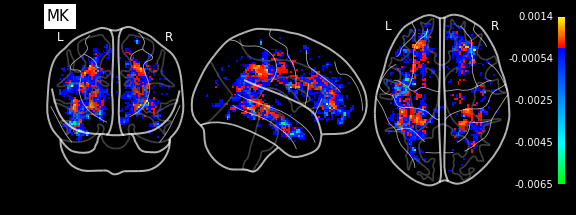

In [125]:
def plot_kmean_coeffs(save, **kwargs):
    save_and_plot(kmean_coeffs, "MK", save, **kwargs)

w=interactive(plot_kmean_coeffs, save=False, neg_disp=nd_slider, pos_disp=pd_slider, 
              plot_abs=False, colorbar=True, black_bg=True, symmetric_cbar=False)
IPython.display.display(w)

about to save MD_color
saved MD_color


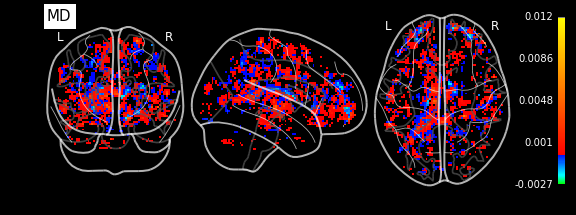

In [126]:
def plot_dmean_coeffs(save, **kwargs):
    save_and_plot(dmean_coeffs, "MD", save, **kwargs)

w=interactive(plot_dmean_coeffs, save=False, neg_disp=nd_slider, pos_disp=pd_slider, 
              plot_abs=False, colorbar=True, black_bg=True, symmetric_cbar=False)
IPython.display.display(w)

about to save FA_color
saved FA_color


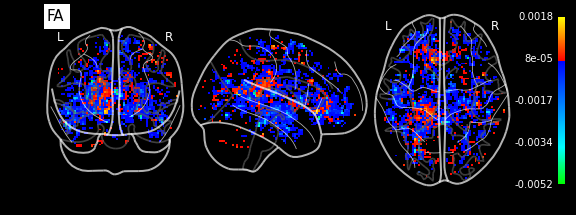

In [127]:
def plot_fa_coeffs(save, **kwargs):
    save_and_plot(fa_coeffs, "FA", save, **kwargs)

w=interactive(plot_fa_coeffs, save=False, neg_disp=nd_slider, pos_disp=pd_slider, 
              plot_abs=False, colorbar=True, black_bg=True, symmetric_cbar=False)
IPython.display.display(w)

# Ensemble Anlysis

In [47]:
ensemble_mat = np.hstack([dmean_mat, fa_mat, kmat])

assert np.all(k_labels_arr == fa_labels_arr)
assert np.all(k_labels_arr == dmean_labels_arr)
labels = k_labels_arr

dist = int(ensemble_mat.shape[1]/3)
index_map = {"dmean": (0, dist),
             "fa":  (dist, 2 * dist),
             "kmean": (2*dist, 3*dist)}

In [48]:
dmean_params, kmean_params, fa_params = [{w[-1]: bp[w]}
 for bp in (dmean_search.best_params_, ksearch.best_params_, fa_search.best_params_)
 for w in bp]
params_map = {'dmean': dmean_params, 'fa': fa_params, 'kmean': kmean_params}

In [49]:
def calc_f1s_ens(index_map=index_map, params_map=params_map):
    def _calc_f1s_ens(bound_info_dict):
        from sklearn.cross_validation import StratifiedShuffleSplit

        ensemble_alg = epi_prediction.ensemble_alg(index_map, params_map)

        print('-' * cv.n_iter)

        for train, test in cv:
            sys.stdout.write('#')
            ensemble_alg.fit(ensemble_mat[train], labels[train])

            expected = labels[test]
            predicted = ensemble_alg.predict(ensemble_mat[test]).flatten()

            bound_info_dict['expected'] = stack_or_set(bound_info_dict['expected'], expected)
            bound_info_dict['predicted'] = stack_or_set(bound_info_dict['predicted'], predicted)

        info = epi_prediction.CvInfo(bound_info_dict['expected'], bound_info_dict['predicted'])
        return info
    
    return _calc_f1s_ens(dict(expected=None, predicted=None))
    

In [50]:
ens_infos = calc_f1s_ens()

----------------------------------------------------------------------------------------------------
####################################################################################################

In [51]:
np.mean(ens_infos.f1_scores())

0.7957326562326561

In [52]:
epi_prediction.ttest_ind_one_tail(ens_infos.f1_scores(), kmean_coeffs_info.f1_scores())

Ttest_indResult(statistic=2.8520873416841868, pvalue=0.0024020951115833423)

In [53]:
epi_prediction.ttest_ind_one_tail(ens_infos.f1_scores(), dmean_coeffs_info.f1_scores())

Ttest_indResult(statistic=6.5846698416040184, pvalue=2.0034706260691568e-10)

In [54]:
epi_prediction.ttest_ind_one_tail(ens_infos.f1_scores(), fa_coeffs_info.f1_scores())

Ttest_indResult(statistic=4.6410022842166967, pvalue=3.1499767589440192e-06)

In [55]:
epi_prediction.ttest_1samp_one_tail(ens_infos.f1_scores(), .5)

Ttest_1sampResult(statistic=27.14423509147354, pvalue=5.8671420020830465e-48)

## Good Results, Compare With Removing Single Modalities

In [56]:
def rm_key(d, k):
    ret = d.copy()
    del ret[k]
    return ret

In [57]:
strip_input = lambda k: (rm_key(index_map, k), rm_key(params_map, k))

ens_infos_no_dmean = calc_f1s_ens(*strip_input('dmean'))
print('')
ens_infos_no_fa = calc_f1s_ens(*strip_input('fa'))
print('')
ens_infos_no_kmean = calc_f1s_ens(*strip_input('kmean'))
print('')

----------------------------------------------------------------------------------------------------
####################################################################################################
----------------------------------------------------------------------------------------------------
####################################################################################################
----------------------------------------------------------------------------------------------------
####################################################################################################


In [58]:
epi_prediction.ttest_ind_one_tail(ens_infos.f1_scores(), ens_infos_no_dmean.f1_scores())

Ttest_indResult(statistic=1.5327210242722227, pvalue=0.063470419362580355)

In [59]:
epi_prediction.ttest_ind_one_tail(ens_infos.f1_scores(), ens_infos_no_kmean.f1_scores())

Ttest_indResult(statistic=3.6138951063605989, pvalue=0.00019124693907792494)

In [60]:
epi_prediction.ttest_ind_one_tail(ens_infos.f1_scores(), ens_infos_no_fa.f1_scores())

Ttest_indResult(statistic=2.3917906987905964, pvalue=0.008851063669995789)

In [61]:
epi_prediction.ttest_ind_one_tail(ens_infos_no_kmean.f1_scores(), kmean_coeffs_info.f1_scores())

Ttest_indResult(statistic=-0.37949564708278083, pvalue=0.35236326681493102)

In [62]:
epi_prediction.ttest_1samp_one_tail(ens_infos_no_kmean.f1_scores(), .5)

Ttest_1sampResult(statistic=19.601845144181365, pvalue=3.7059247557728611e-36)

### Paper Statistics

In [114]:
def paper_info(info):
    pretty = lambda n: "%.3f" % n
    avg = lambda fn: pretty(getattr(info, 'avg_' + fn)())
    std = lambda fn: pretty(np.std(getattr(info, fn + 's')()))
    score_fns = ('sensitivity_score', 'specificity_score', 'f1_score')
    res = [f[:-6] + ' mean: ' + avg(f) + ' std: ' + std(f) for f in score_fns]
    print "\n".join(res)

In [115]:
print('All 3')
paper_info(ens_infos)

All 3
sensitivity mean: 0.785 std: 0.157
specificity mean: 0.820 std: 0.168
f1 mean: 0.796 std: 0.108


In [110]:
print('No FA')
paper_info(ens_infos_no_fa)

No FA
sensitivity mean: 0.738 std: 0.159
specificity mean: 0.797 std: 0.186
f1 mean: 0.758 std: 0.114


In [109]:
print('No MD')
paper_info(ens_infos_no_dmean)

No MD
sensitivity mean: 0.748 std: 0.164
specificity mean: 0.822 std: 0.146
f1 mean: 0.771 std: 0.117


In [111]:
print('No MK')
paper_info(ens_infos_no_kmean)

No MK
sensitivity mean: 0.717 std: 0.169
specificity mean: 0.783 std: 0.185
f1 mean: 0.737 std: 0.120


In [116]:
def compare_with_kmean(info):
    return epi_prediction.ttest_ind_one_tail(info.f1_scores(), kmean_coeffs_info.f1_scores())

In [117]:
compare_with_kmean(ens_infos)

Ttest_indResult(statistic=2.8520873416841868, pvalue=0.0024020951115833423)

In [118]:
compare_with_kmean(ens_infos_no_dmean)

Ttest_indResult(statistic=1.4558581408239222, pvalue=0.073507799023458359)

In [119]:
compare_with_kmean(ens_infos_no_fa)

Ttest_indResult(statistic=0.7464843891124352, pvalue=0.22813013993074893)

In [120]:
compare_with_kmean(ens_infos_no_kmean)

Ttest_indResult(statistic=-0.37949564708278083, pvalue=0.35236326681493102)

In [121]:
compare_with_kmean(kmean_coeffs_info)

Ttest_indResult(statistic=0.0, pvalue=0.5)

In [122]:
paper_info(kmean_coeffs_info)

sensitivity mean: 0.717 std: 0.196
specificity mean: 0.815 std: 0.156
f1 mean: 0.744 std: 0.144


In [123]:
paper_info(dmean_coeffs_info)

sensitivity mean: 0.687 std: 0.172
specificity mean: 0.707 std: 0.186
f1 mean: 0.687 std: 0.123


In [124]:
paper_info(fa_coeffs_info)

sensitivity mean: 0.677 std: 0.179
specificity mean: 0.808 std: 0.172
f1 mean: 0.717 std: 0.130


### Bar Plot

In [232]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
width = .5

bar_info = lambda title, info, sort: dict(title=title, info=info, sort=sort)

look_up = sorted([
    bar_info('MD', dmean_coeffs_info, sort=0), 
    bar_info('FA', fa_coeffs_info, sort=1),
    bar_info('MK', kmean_coeffs_info, sort=2),
    bar_info('All', ens_infos, sort=3),
    bar_info('MK+FA', ens_infos_no_dmean, sort=4),
    bar_info('MK+MD', ens_infos_no_fa, sort=5),
    bar_info('FA+MD', ens_infos_no_kmean, sort=6)],
                 key=lambda i: i['sort'])

def add_bar(info, i):
    f1s = info.f1_scores()
    std = np.std(f1s)
    tstat, pval = epi_prediction.ttest_ind_one_tail(kmean_coeffs_info.f1_scores(), f1s)
    color = 'y' if pval < .05 else 'b'
    bottom = .55
    return ax.bar([i], info.avg_f1_score() - bottom, width=width, yerr=std, 
                  ecolor='k', color=color, bottom=bottom)


bars = [add_bar(k['info'], k['sort']) for k in look_up]
    
ax.set_xticklabels([k['title'] for k in look_up])
ax.set_xticks([k['sort'] + width/2 for k in look_up])
ax.legend([bars[0], bars[1]], ['p < .05 (vs MK)', 'p > .05 (vs MK)'])
ax.axhline(kmean_coeffs_info.avg_f1_score(), linestyle='--', color='k')
ax.set_title('F1-Score by Diffusion Measure')

def save_bars(save):
    if save:
        f_name = "bars.png"
        print("saved " + f_name)
        fig.savefig(f_name, dpi=72)
        
w=interactive(save_bars, save=False)
IPython.display.display(w)

saved bars.png
